# Mesh Tutorial 2: Operations and Transformations

This tutorial covers mesh manipulation operations in PhysicsNeMo-Mesh:

1. **Geometric Transformations**: translate, rotate, scale, arbitrary linear transforms
2. **Subdivision**: Refine meshes with different smoothing schemes
3. **Slicing**: Extract subsets of points or cells
4. **Merging**: Combine multiple meshes into one
5. **Boundary & Facet Extraction**: Get boundaries and lower-dimensional elements
6. **Data Conversion**: Move data between points and cells
7. **Topology Checks**: Watertight and manifold detection

In [30]:
import torch
import math

from physicsnemo.mesh import Mesh
from physicsnemo.mesh.primitives.surfaces import sphere_icosahedral
from physicsnemo.mesh.primitives.volumes import cube_volume

## Section 1: Geometric Transformations

PhysicsNeMo-Mesh provides standard geometric transformations that operate on the mesh geometry.
All transformations return a **new mesh** (they don't modify in place).

### Translation

Move all points by a fixed offset vector.

In [31]:
sphere = sphere_icosahedral.load(subdivisions=2)

# Translate by a vector
translated = sphere.translate([5.0, 0.0, 0.0])

print(f"Original center: {sphere.points.mean(dim=0)}")
print(f"Translated center: {translated.points.mean(dim=0)}")

Original center: tensor([ 7.3586e-10, -1.4717e-09, -1.4717e-09])
Translated center: tensor([ 5.0000e+00, -1.4717e-09, -1.4717e-09])


### Scaling

Scale the mesh uniformly or anisotropically (different factors per axis).

Original extent: tensor([2., 2., 2.])
Uniform 2x: tensor([4., 4., 4.])
Anisotropic: tensor([4., 2., 1.])


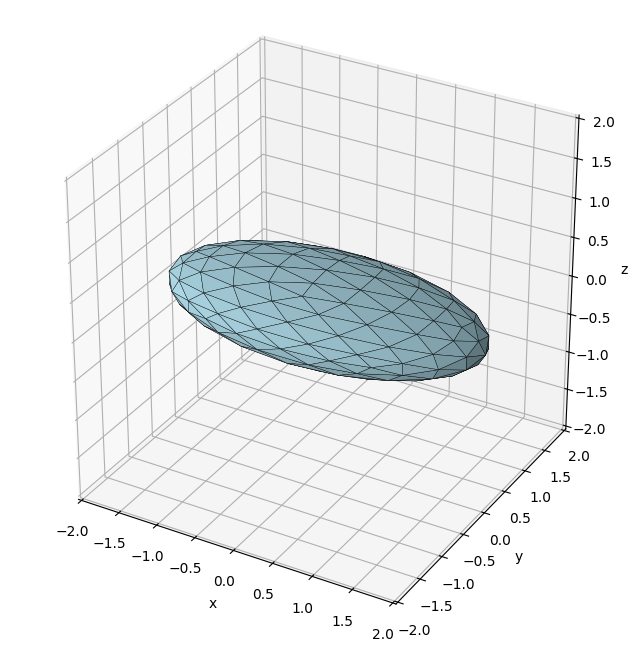

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [32]:
sphere = sphere_icosahedral.load(subdivisions=2)

# Uniform scaling: double the size
scaled_uniform = sphere.scale(2.0)
print(
    f"Original extent: {sphere.points.max(dim=0).values - sphere.points.min(dim=0).values}"
)
print(
    f"Uniform 2x: {scaled_uniform.points.max(dim=0).values - scaled_uniform.points.min(dim=0).values}"
)

# Anisotropic scaling: stretch into an ellipsoid
scaled_aniso = sphere.scale([2.0, 1.0, 0.5])
print(
    f"Anisotropic: {scaled_aniso.points.max(dim=0).values - scaled_aniso.points.min(dim=0).values}"
)

# Visualize the ellipsoid
scaled_aniso.draw(backend="matplotlib")

### Rotation

Rotate around an axis by a specified angle (in radians).

- For **2D meshes**: No axis needed (rotation is in the plane)
- For **3D meshes**: Specify the rotation axis

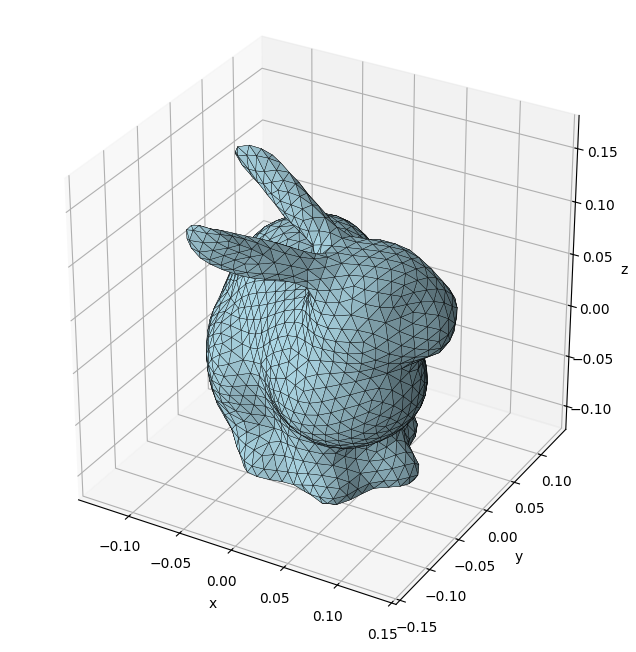

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [33]:
# Load the bunny for a more interesting example
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(1, "loop")

# Rotate 45 degrees around the Z-axis
rotated_z = bunny.rotate(angle=math.pi / 4, axis=[0, 0, 1])

# Rotate 90 degrees around the Y-axis
rotated_y = bunny.rotate(angle=math.pi / 2, axis=[0, 1, 0])

# Rotation around an arbitrary axis
rotated_arbitrary = bunny.rotate(angle=math.pi / 3, axis=[1, 1, 1])

rotated_z.draw(backend="matplotlib")

**Higher-dimensional meshes:** `rotate()` only supports 2D and 3D spatial dimensions. In 2D,
rotation is in the plane (no axis needed). In 3D, rotation is specified by an angle and axis
(Rodrigues' formula). For meshes with 4 or more spatial dimensions, rotation is not uniquely
defined by a single angle and axis - construct a rotation matrix directly and use `transform()`
instead.

### Arbitrary Linear Transform

Apply any linear transformation via a matrix. This is the most general transformation,
encompassing rotation, scaling, shearing, and even projection to different dimensions.

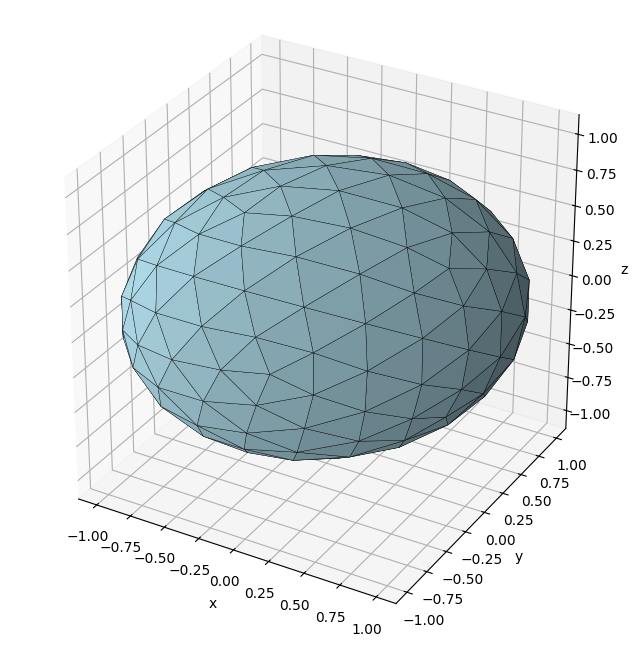

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [34]:
sphere = sphere_icosahedral.load(subdivisions=2)

# Shear transformation
shear_matrix = torch.tensor(
    [
        [1.0, 0.5, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)
sheared = sphere.transform(shear_matrix)
sheared.draw(backend="matplotlib")

Original: 3D
Projected: 2D


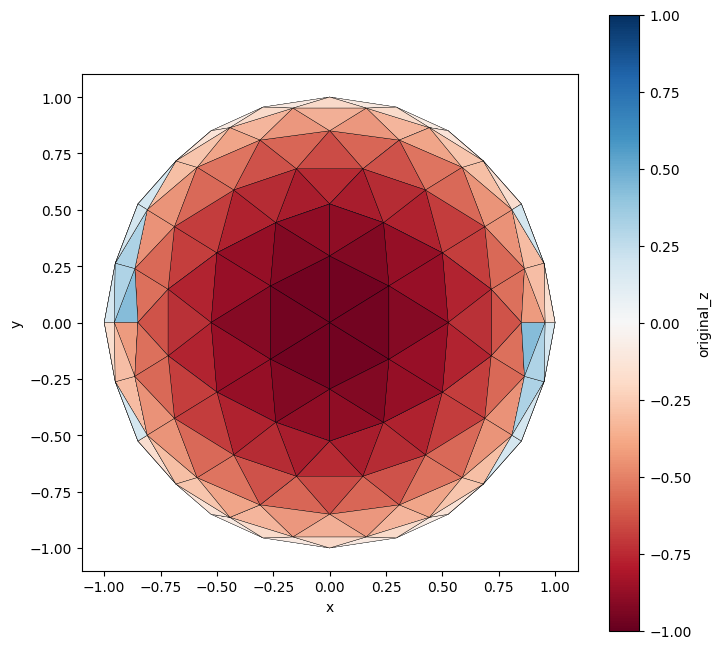

<Axes: xlabel='x', ylabel='y'>

In [35]:
# Projection to 2D (drop the z coordinate)
projection_matrix = torch.tensor(
    [
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
    ]
)

# Save the original z-coordinate as a scalar field before projecting.
# This makes the overlap visible: front (z > 0) and back (z < 0) hemispheres
# map to the same 2D positions, but the color distinguishes them.
sphere.point_data["original_z"] = sphere.points[:, 2]

projected = sphere.transform(projection_matrix)
print(f"Original: {sphere.n_spatial_dims}D")
print(f"Projected: {projected.n_spatial_dims}D")
projected.draw(point_scalars="original_z", cmap="RdBu", backend="matplotlib")

The `[[1,0,0],[0,1,0]]` projection drops the z-coordinate, so the front hemisphere
(z > 0, red) and back hemisphere (z < 0, blue) map to identical 2D positions and overlap
perfectly. The coloring by original z-value reveals this: you can see both colors bleeding
through where the two hemispheres coincide. This is expected - the icosahedral sphere has
mirror symmetry about the z-axis, so the x-y projection of the front and back are identical.

## Section 2: Subdivision

Subdivision refines a mesh by splitting each cell into smaller cells. This is useful for:
- Increasing mesh resolution
- Smoothing coarse meshes
- Creating smooth surfaces from control meshes

PhysicsNeMo-Mesh supports three subdivision schemes:

| Scheme | Type | Properties |
|--------|------|------------|
| `linear` | Interpolating | Midpoint subdivision, preserves original vertices |
| `loop` | Approximating | C² smooth, moves original vertices |
| `butterfly` | Interpolating | Smooth, preserves original vertices |

In [36]:
# Start with a coarse icosahedron (20 triangles)
coarse = sphere_icosahedral.load(subdivisions=0)
print(f"Coarse: {coarse.n_points} points, {coarse.n_cells} cells")

# Each level of subdivision multiplies cells by 4 (for triangles)
linear_1 = coarse.subdivide(levels=1, filter="linear")
linear_2 = coarse.subdivide(levels=2, filter="linear")
linear_3 = coarse.subdivide(levels=3, filter="linear")

print(f"Linear 1 level: {linear_1.n_points} points, {linear_1.n_cells} cells")
print(f"Linear 2 levels: {linear_2.n_points} points, {linear_2.n_cells} cells")
print(f"Linear 3 levels: {linear_3.n_points} points, {linear_3.n_cells} cells")

Coarse: 12 points, 20 cells
Linear 1 level: 42 points, 80 cells
Linear 2 levels: 162 points, 320 cells
Linear 3 levels: 642 points, 1280 cells


Linear subdivision (faceted):


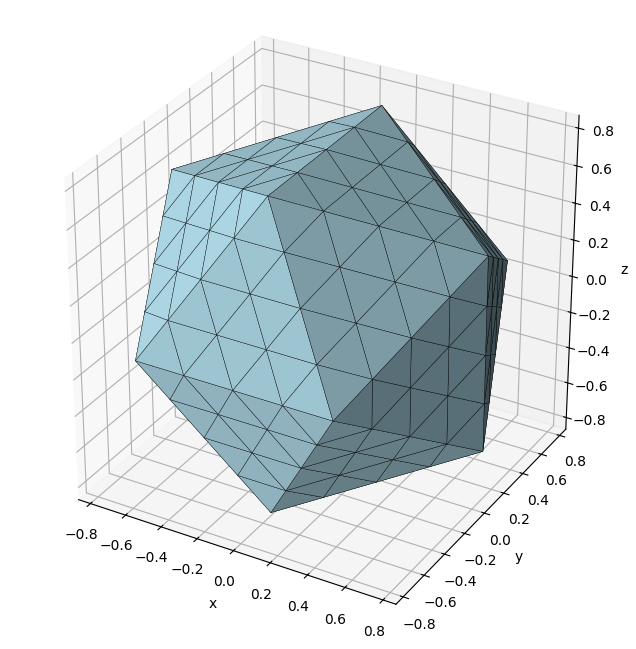

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [37]:
# Compare subdivision schemes on a coarse mesh
coarse = sphere_icosahedral.load(subdivisions=0)

# Linear: just splits cells, doesn't smooth
linear = coarse.subdivide(levels=2, filter="linear")

# Loop: C² smooth, approximating (moves original vertices)
loop = coarse.subdivide(levels=2, filter="loop")

# Butterfly: smooth, interpolating (preserves original vertices)
butterfly = coarse.subdivide(levels=2, filter="butterfly")

print("Linear subdivision (faceted):")
linear.draw(backend="matplotlib")

Loop subdivision (smooth, C²):


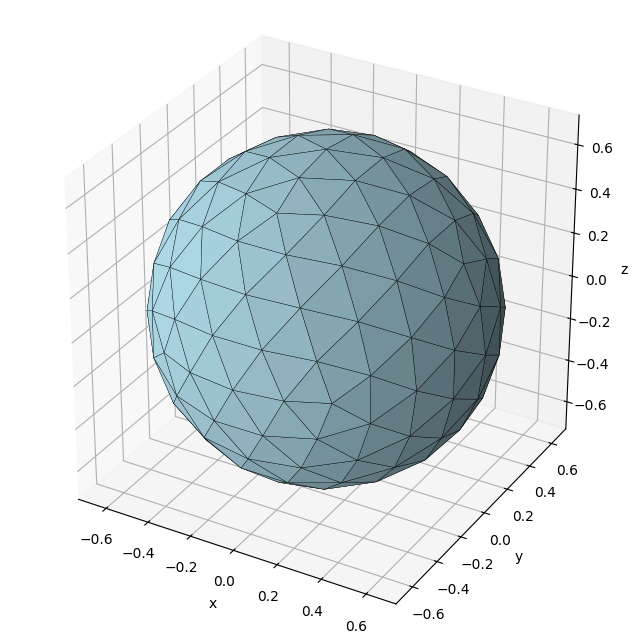

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [38]:
print("Loop subdivision (smooth, C²):")
loop.draw(backend="matplotlib")

Butterfly subdivision (smooth, interpolating):


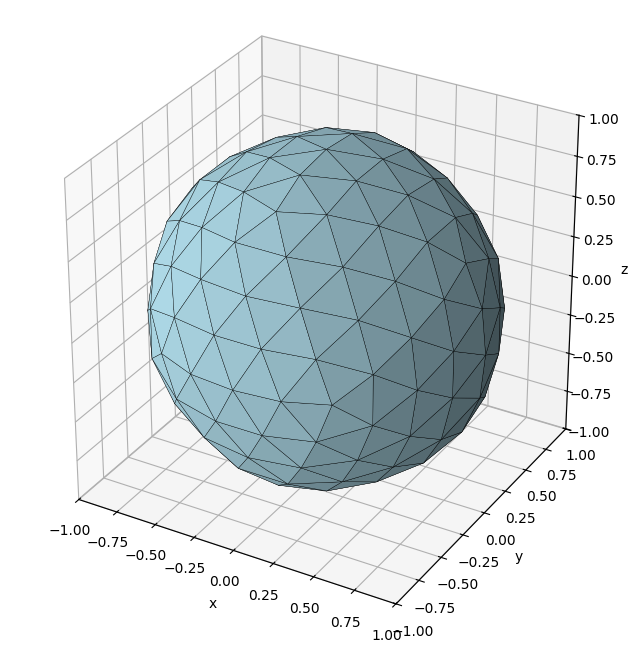

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [39]:
print("Butterfly subdivision (smooth, interpolating):")
butterfly.draw(backend="matplotlib")

### Data Interpolation During Subdivision

When you subdivide a mesh with attached data, the data is automatically interpolated
to the new vertices and cells.

Before: 42 points
After: 642 points
Data keys preserved: ['height']


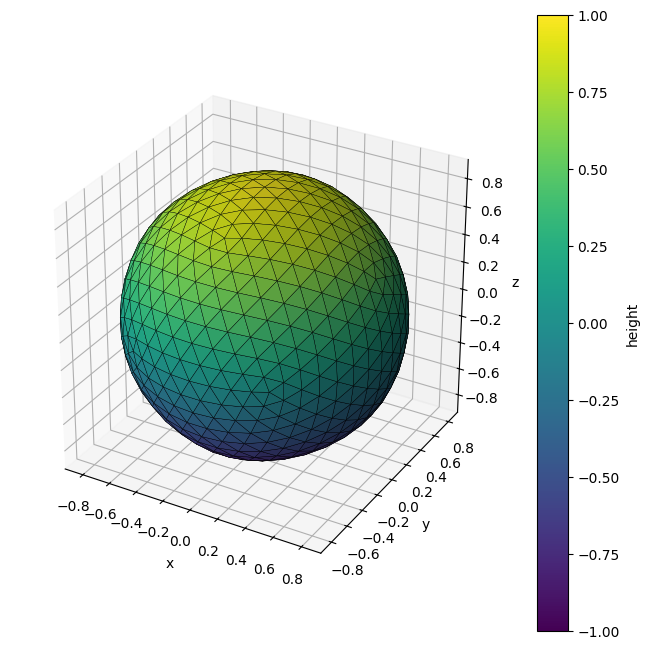

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [40]:
# Create a mesh with data
mesh = sphere_icosahedral.load(subdivisions=1)

# Add a scalar field based on z-coordinate
mesh.point_data["height"] = mesh.points[:, 2]
print(f"Before: {mesh.n_points} points")

# Subdivide - data is interpolated automatically
refined = mesh.subdivide(levels=2, filter="loop")
print(f"After: {refined.n_points} points")
print(f"Data keys preserved: {list(refined.point_data.keys())}")

refined.draw(point_scalars="height", cmap="viridis", backend="matplotlib")

## Section 3: Slicing

Slicing extracts a subset of points or cells from a mesh. You can slice by:
- Integer indices
- Boolean masks
- Index arrays

### Slicing Cells

`slice_cells()` keeps only the specified cells. Points are preserved (even unused ones).

Original: 320 cells
X > 0: 152 cells


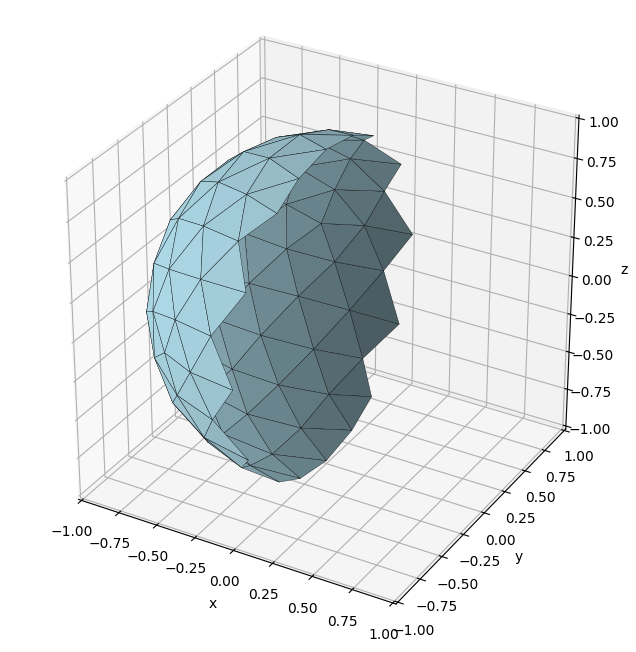

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [41]:
sphere = sphere_icosahedral.load(subdivisions=2)
print(f"Original: {sphere.n_cells} cells")

# Slice using a boolean mask: keep cells with positive x-centroid
mask = sphere.cell_centroids[:, 0] < 0
hemisphere_x = sphere.slice_cells(mask)
print(f"X > 0: {hemisphere_x.n_cells} cells")

hemisphere_x.draw(backend="matplotlib")

Calling `.clean()` will remove unused points and make cell indices contiguous.

X > 0 and Z > 0: 72 cells


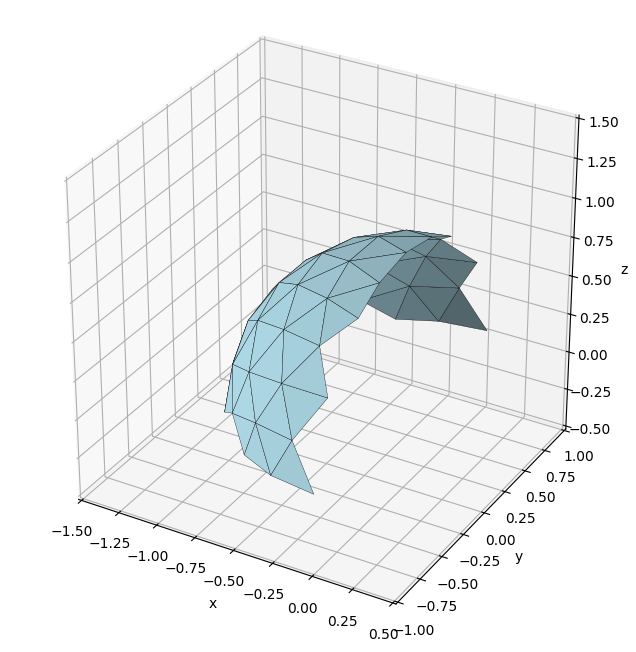

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [42]:
# Slice with compound conditions
mask = (sphere.cell_centroids[:, 0] < 0) & (sphere.cell_centroids[:, 2] > 0)
quadrant = sphere.slice_cells(mask).clean()
print(f"X > 0 and Z > 0: {quadrant.n_cells} cells")

quadrant.draw(backend="matplotlib")

In [43]:
# Slice by index array
indices = torch.arange(0, sphere.n_cells, 2)  # Every other cell
every_other = sphere.slice_cells(indices)
print(f"Every other cell: {every_other.n_cells} cells")

Every other cell: 160 cells


### Slicing Points

`slice_points()` keeps only the specified points. Cells that reference removed points
are automatically removed, and remaining cell indices are remapped.

Original: 162 points, 320 cells
Z > 0: 73 points, 122 cells


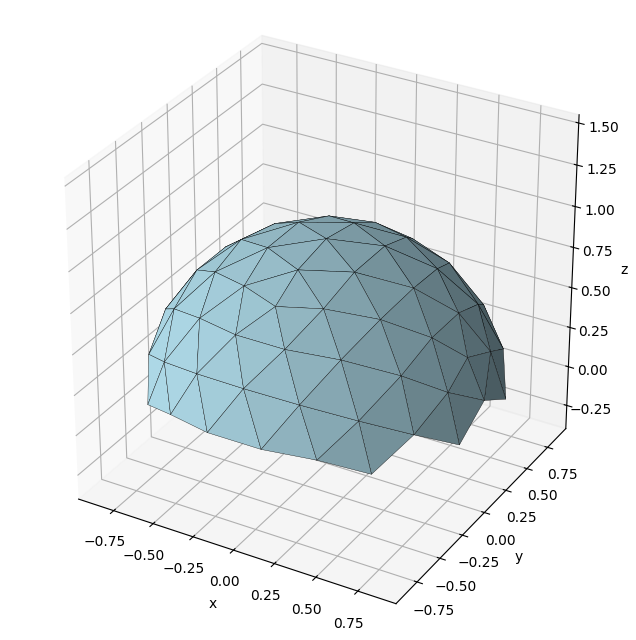

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [44]:
sphere = sphere_icosahedral.load(subdivisions=2)
print(f"Original: {sphere.n_points} points, {sphere.n_cells} cells")

# Keep only points with z > 0
mask = sphere.points[:, 2] > 0
top_half = sphere.slice_points(mask)
print(f"Z > 0: {top_half.n_points} points, {top_half.n_cells} cells")

# Note: cells that cross z=0 are removed (they reference deleted points)
top_half.draw(backend="matplotlib")

## Section 4: Merging Meshes

`Mesh.merge()` combines multiple meshes into a single mesh. The meshes must have:
- Same spatial dimension
- Same manifold dimension
- Same cell_data keys (if any)

Sphere 1: 162 points, 320 cells
Sphere 2: 162 points, 320 cells
Sphere 3: 162 points, 320 cells

Merged: 486 points, 960 cells


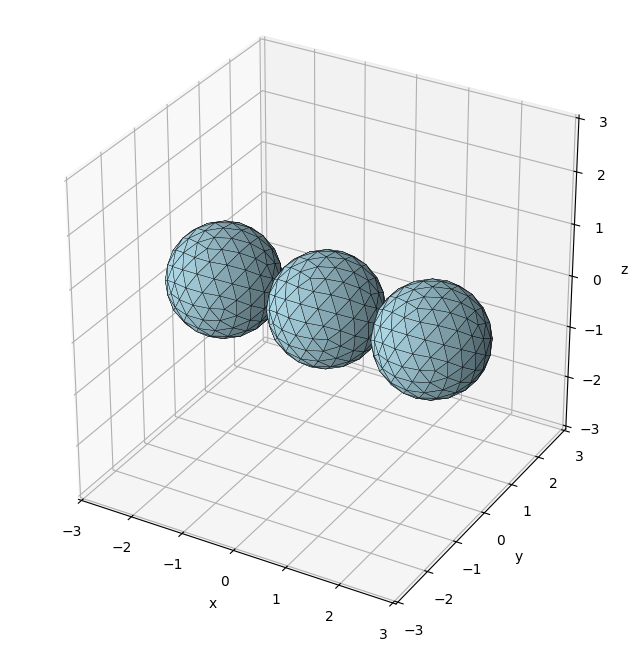

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [45]:
# Create three spheres at different positions
sphere1 = sphere_icosahedral.load(subdivisions=2).translate([-2.0, 0.0, 0.0])
sphere2 = sphere_icosahedral.load(subdivisions=2).translate([0.0, 0.0, 0.0])
sphere3 = sphere_icosahedral.load(subdivisions=2).translate([2.0, 0.0, 0.0])

print(f"Sphere 1: {sphere1.n_points} points, {sphere1.n_cells} cells")
print(f"Sphere 2: {sphere2.n_points} points, {sphere2.n_cells} cells")
print(f"Sphere 3: {sphere3.n_points} points, {sphere3.n_cells} cells")

# Merge them
merged = Mesh.merge([sphere1, sphere2, sphere3])
print(f"\nMerged: {merged.n_points} points, {merged.n_cells} cells")

merged.draw(backend="matplotlib")

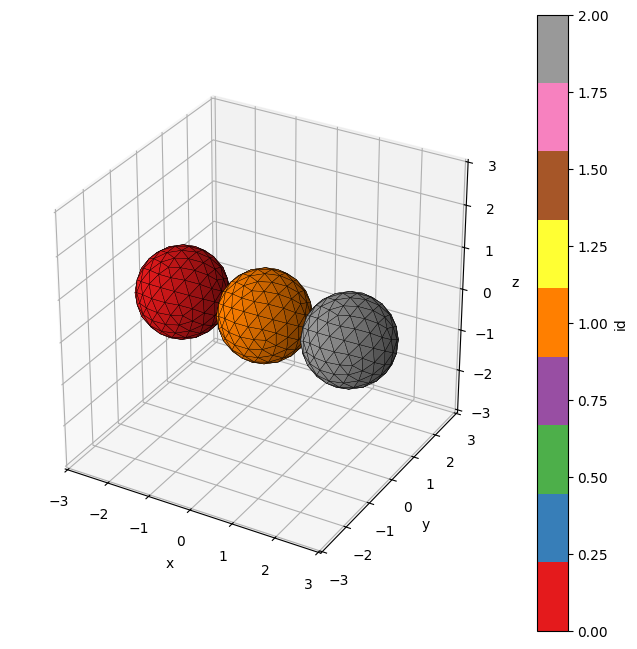

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [46]:
# Merge preserves attached data
sphere1.point_data["id"] = torch.full((sphere1.n_points,), 0.0)
sphere2.point_data["id"] = torch.full((sphere2.n_points,), 1.0)
sphere3.point_data["id"] = torch.full((sphere3.n_points,), 2.0)

merged = Mesh.merge([sphere1, sphere2, sphere3])
merged.draw(point_scalars="id", cmap="Set1", backend="matplotlib")

**Merging requires matching dimensions.** All meshes passed to `Mesh.merge()` must have the
same spatial dimension *and* the same manifold dimension. This is a fundamental constraint:
the `cells` tensor has a fixed width (`n_manifold_dims + 1`), so mixing triangles and tetrahedra
in a single mesh is not possible.

For structures that pair meshes of different manifold dimensions - e.g., a tetrahedral volume
mesh and its triangular boundary surface, as in a DrivAerML-style problem - use separate `Mesh`
objects. You can apply the same transformation to both:

```python
rotation_args = dict(angle=math.pi / 4, axis=[0, 1, 0])
volume_mesh = volume_mesh.rotate(**rotation_args)
surface_mesh = surface_mesh.rotate(**rotation_args)
```

Future versions of the Mesh library may support a collection object to facilitate multi-dimensional meshes.

## Section 5: Boundary and Facet Extraction

PhysicsNeMo-Mesh can extract:
- **Boundary mesh**: Only the facets that are on the boundary (shared by exactly 1 cell)
- **Facet mesh**: All (n-k)-dimensional facets of an n-dimensional mesh

### Boundary Extraction

Extract the boundary surface of a volume mesh. We'll show this step by step to
make the structure clear.

Volume mesh: Mesh(manifold_dim=3, spatial_dim=3, n_points=125, n_cells=384)
    point_data : {}
    cell_data  : {}
    global_data: {}
  Manifold dim: 3 (tetrahedra)

Sliced (x < 0): 192 cells
Sliced volume mesh (reveals interior tetrahedra):


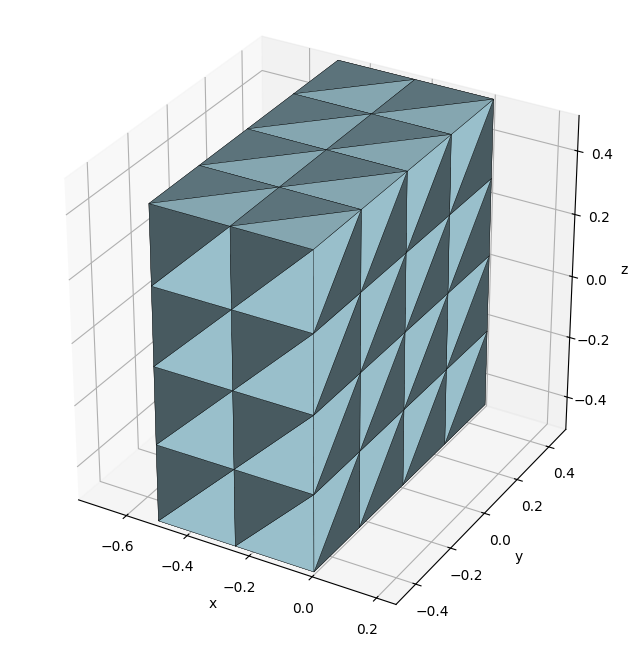

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [49]:
# Step 1: Load a tetrahedral volume mesh
cube = cube_volume.load(subdivisions=4).clean()
print(f"Volume mesh: {cube}")
print(f"  Manifold dim: {cube.n_manifold_dims} (tetrahedra)")

# Step 2: Slice to reveal the interior - this shows the mesh is filled with tetrahedra
sliced = cube.slice_cells(cube.cell_centroids[:, 0] < 0).clean()
print(f"\nSliced (x < 0): {sliced.n_cells} cells")
print("Sliced volume mesh (reveals interior tetrahedra):")
sliced.draw(backend="matplotlib")

Boundary mesh: Mesh(manifold_dim=2, spatial_dim=3, n_points=98, n_cells=192)
    point_data : {}
    cell_data  : {}
    global_data: {}
  Manifold dim: 2 (triangles)
Boundary surface (hollow - no interior tetrahedra):


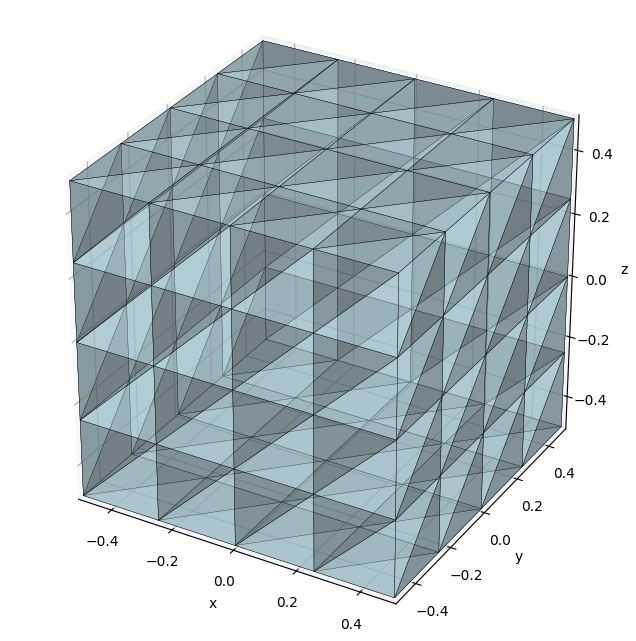

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [50]:
# Step 3: Extract the boundary surface - only the outer shell
boundary = cube.get_boundary_mesh().clean()
print(f"Boundary mesh: {boundary}")
print(f"  Manifold dim: {boundary.n_manifold_dims} (triangles)")
print("Boundary surface (hollow - no interior tetrahedra):")
boundary.draw(alpha_cells=0.5, backend="matplotlib")

Boundary edges: Mesh(manifold_dim=1, spatial_dim=3, n_points=98, n_cells=288)
    point_data : {}
    cell_data  : {}
    global_data: {}
  Manifold dim: 1 (edges)
Wireframe of boundary surface:


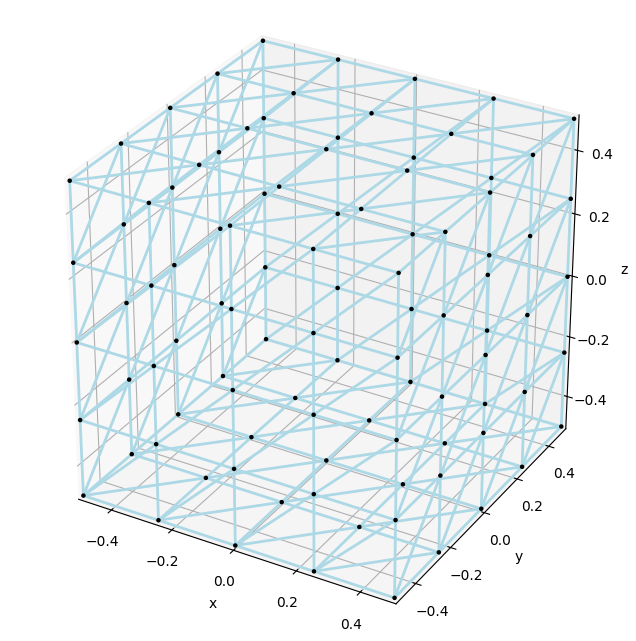

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [51]:
# Step 4: Extract edges from the boundary surface (boundary of the boundary = wireframe)
boundary_edges = boundary.get_facet_mesh(manifold_codimension=1).clean()
print(f"Boundary edges: {boundary_edges}")
print(f"  Manifold dim: {boundary_edges.n_manifold_dims} (edges)")
print("Wireframe of boundary surface:")
boundary_edges.draw(backend="matplotlib")

One immediate application of this facet extraction we just performed - where we converted a volume mesh into a wireframe - is that this is actually an undirected graph data structure. In fact, a 1D simplicial complex as represented in PhysicsNeMo-Mesh is just a geometric embedding of an undirected graph! Because of this, Mesh can be readily used to generate and manipulate graph data, such as those found in MeshGraphNet-family architectures.

One interesting edge case is the boundary of a closed surface mesh - it is empty. So, if we take the boundary of a sphere (as distinguished from a ball), we get an empty mesh:

In [52]:
# For a closed surface mesh, the boundary is empty
sphere = sphere_icosahedral.load(subdivisions=2)
sphere_boundary = sphere.get_boundary_mesh()
print(
    f"Sphere boundary: {sphere_boundary.n_cells} cells (should be 0 for closed surface)"
)

Sphere boundary: 0 cells (should be 0 for closed surface)


### Facet Extraction

While `get_boundary_mesh()` extracts only boundary facets (those shared by exactly 1 cell),
`get_facet_mesh()` extracts **all** sub-simplices - including interior ones shared by
multiple cells.

The `manifold_codimension` parameter controls how many dimensions to step down:

| Parent cells | `manifold_codimension` | Result | Per-cell count |
|---|---|---|---|
| Triangles (2-simplices) | 1 | Edges (1-simplices) | 3 edges per triangle |
| Triangles (2-simplices) | 2 | Vertices (0-simplices) | 3 vertices per triangle |
| Tetrahedra (3-simplices) | 1 | Triangles (2-simplices) | 4 faces per tet |
| Tetrahedra (3-simplices) | 2 | Edges (1-simplices) | 6 edges per tet |

In general, codimension *k* extracts (n-k)-simplices from n-simplices, producing
C(n+1, n+1-k) candidates per cell (before deduplication of shared sub-simplices).

For example, extracting the edge mesh from a triangle mesh gives you an undirected graph:

Triangle mesh: Mesh(manifold_dim=2, spatial_dim=3, n_points=42, n_cells=80)
    point_data : {}
    cell_data  : {}
    global_data: {}

Edge mesh: Mesh(manifold_dim=1, spatial_dim=3, n_points=42, n_cells=120)
    point_data : {}
    cell_data  : {}
    global_data: {}
  Each edge is shared by 2 triangles (interior) or 1 triangle (boundary)


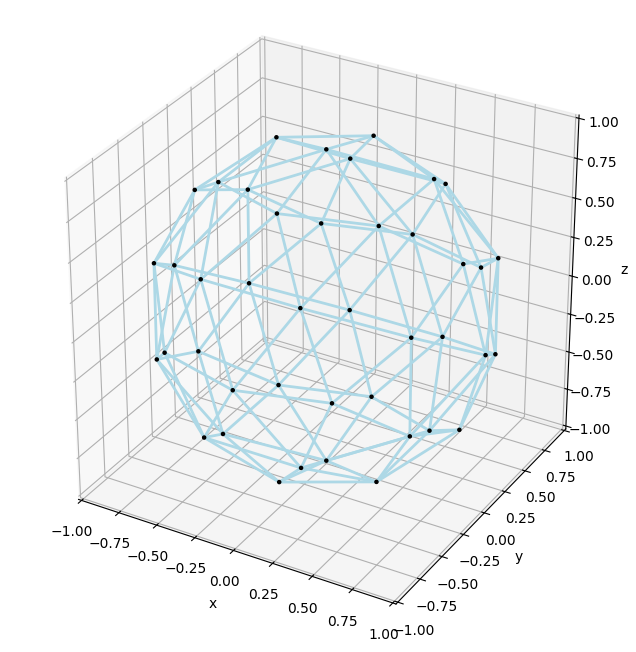

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [53]:
# Extract all edges from a triangle mesh
sphere = sphere_icosahedral.load(subdivisions=1)
print(f"Triangle mesh: {sphere}")

# Get codimension-1 facets: triangles -> edges
edges = sphere.get_facet_mesh(manifold_codimension=1)
print(f"\nEdge mesh: {edges}")
print(f"  Each edge is shared by 2 triangles (interior) or 1 triangle (boundary)")

edges.draw(backend="matplotlib")

In [54]:
# Extract all faces from a tetrahedral mesh
cube = cube_volume.load(subdivisions=3)
print(f"Tet mesh: {cube}")

# Codimension-1: tetrahedra -> triangular faces
all_faces = cube.get_facet_mesh(manifold_codimension=1)
print(f"All triangular faces: {all_faces}")

# Codimension-2: tetrahedra -> edges
all_edges = cube.get_facet_mesh(manifold_codimension=2)
print(f"All edges: {all_edges}")

Tet mesh: Mesh(manifold_dim=3, spatial_dim=3, n_points=64, n_cells=162)
    point_data : {}
    cell_data  : {}
    global_data: {}
All triangular faces: Mesh(manifold_dim=2, spatial_dim=3, n_points=64, n_cells=378)
    point_data : {}
    cell_data  : {}
    global_data: {}
All edges: Mesh(manifold_dim=1, spatial_dim=3, n_points=64, n_cells=279)
    point_data : {}
    cell_data  : {}
    global_data: {}


## Section 6: Data Conversion

Sometimes you need to move data between points and cells:
- **cell_data_to_point_data**: Average cell values to vertices
- **point_data_to_cell_data**: Average vertex values to cells

These methods convert **all** data fields at once. If you only want to convert specific
fields, construct a temporary mesh with just those fields:

```python
# Convert only "temperature" from point_data to cell_data
from tensordict import TensorDict
temp_mesh = Mesh(
    points=mesh.points, cells=mesh.cells,
    point_data=TensorDict({"temperature": mesh.point_data["temperature"]},
                           batch_size=[mesh.n_points]),
)
result = temp_mesh.point_data_to_cell_data()
```

In [55]:
mesh = sphere_icosahedral.load(subdivisions=2)

# Create cell data
mesh.cell_data["cell_value"] = torch.randn(mesh.n_cells)
print(f"Before: point_data keys = {list(mesh.point_data.keys())}")

# Convert to point data (averages from adjacent cells)
mesh_with_point_data = mesh.cell_data_to_point_data()
print(f"After: point_data keys = {list(mesh_with_point_data.point_data.keys())}")

Before: point_data keys = []
After: point_data keys = ['cell_value']


Before: cell_data keys = []
After: cell_data keys = ['temperature']


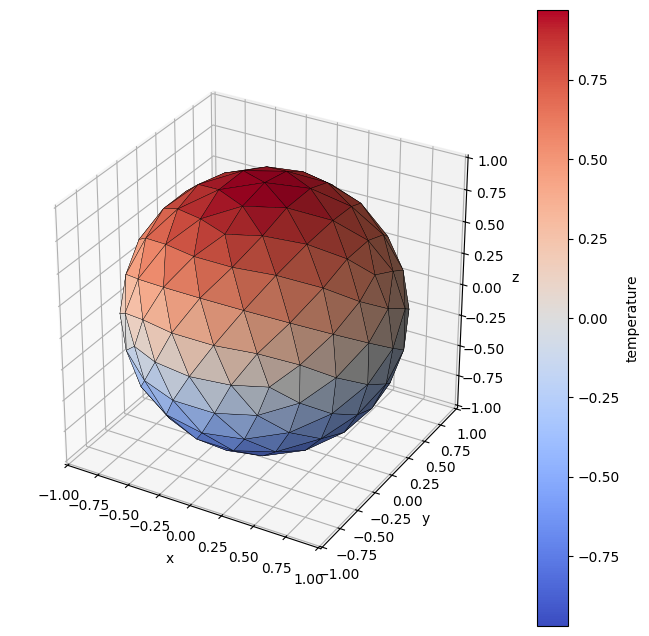

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [56]:
# Convert point data to cell data
mesh = sphere_icosahedral.load(subdivisions=2)
mesh.point_data["temperature"] = mesh.points[:, 2]  # z-coordinate as temperature

print(f"Before: cell_data keys = {list(mesh.cell_data.keys())}")

mesh_with_cell_data = mesh.point_data_to_cell_data()
print(f"After: cell_data keys = {list(mesh_with_cell_data.cell_data.keys())}")

mesh_with_cell_data.draw(
    cell_scalars="temperature", cmap="coolwarm", backend="matplotlib"
)

## Section 7: Topology Checks

PhysicsNeMo-Mesh can check topological properties of meshes.

### Watertight Check

A mesh is **watertight** (or "closed") if it has no boundary - every facet is shared
by exactly 2 cells.

In [57]:
# Closed sphere - watertight
sphere = sphere_icosahedral.load(subdivisions=2)
print(f"Sphere is watertight: {sphere.is_watertight()}")

# Hemisphere - not watertight (has boundary)
hemisphere = sphere.slice_cells(sphere.cell_centroids[:, 2] > 0)
print(f"Hemisphere is watertight: {hemisphere.is_watertight()}")

Sphere is watertight: True
Hemisphere is watertight: False


### Manifold Check

A mesh is a **manifold** if it locally looks like Euclidean space at every point.
Non-manifold meshes have edges shared by more than 2 faces or "pinched" vertices.

In [58]:
# Valid manifold
sphere = sphere_icosahedral.load(subdivisions=2)
print(f"Sphere is manifold: {sphere.is_manifold()}")

# Also valid manifold (with boundary)
hemisphere = sphere.slice_cells(sphere.cell_centroids[:, 2] > 0)
print(f"Hemisphere is manifold: {hemisphere.is_manifold()}")

Sphere is manifold: True
Hemisphere is manifold: True


If a mesh is watertight, it implies that it is manifold, but not vice versa.

### Non-Manifold Examples

Here are two classic examples of non-manifold meshes:

1. **Non-manifold edge**: Three triangles sharing a single edge. In a valid manifold, each
   interior edge is shared by exactly 2 faces. When 3 or more faces meet at an edge,
   the mesh fails to be locally Euclidean there.

2. **Pinch point (non-manifold vertex)**: Two tetrahedra that share only a single vertex
   but no common edge or face. The neighborhood of the shared vertex consists of two
   disconnected pieces, which violates the manifold condition.

In [59]:
# Example 1: Non-manifold edge - three triangles sharing edge [0, 1]
non_manifold_edge = Mesh(
    points=torch.tensor(
        [[0.0, 0.0], [1.0, 0.0], [0.5, 1.0], [0.5, -1.0]],
    ),
    cells=torch.tensor(
        [[0, 1, 2], [1, 0, 3], [0, 1, 3]],  # 3 triangles on the same edge
        dtype=torch.int64,
    ),
)
print(f"Non-manifold edge mesh is manifold: {non_manifold_edge.is_manifold()}")

# Example 2: Pinch point - two tets sharing only vertex 0
non_manifold_pinch = Mesh(
    points=torch.tensor(
        [
            [0.0, 0.0, 0.0],  # shared vertex (pinch point)
            [1.0, 0.0, 0.0],  # tet 1 only
            [0.0, 1.0, 0.0],  # tet 1 only
            [0.0, 0.0, 1.0],  # tet 1 only
            [-1.0, 0.0, 0.0],  # tet 2 only
            [0.0, -1.0, 0.0],  # tet 2 only
            [0.0, 0.0, -1.0],  # tet 2 only
        ],
    ),
    cells=torch.tensor(
        [[0, 1, 2, 3], [0, 4, 5, 6]],
        dtype=torch.int64,
    ),
)
print(f"Pinch-point mesh is manifold: {non_manifold_pinch.is_manifold()}")

Non-manifold edge mesh is manifold: False
Pinch-point mesh is manifold: False


## Summary

In this tutorial, you learned how to manipulate meshes:

1. **Transformations**: `translate()`, `rotate()`, `scale()`, `transform()`
2. **Subdivision**: `subdivide(levels, filter)` with linear/loop/butterfly schemes
3. **Slicing**: `slice_cells()` and `slice_points()` with masks or indices
4. **Merging**: `Mesh.merge([mesh1, mesh2, ...])`
5. **Boundaries**: `get_boundary_mesh()` and `get_facet_mesh()`
6. **Data conversion**: `cell_data_to_point_data()` and `point_data_to_cell_data()`
7. **Topology**: `is_watertight()` and `is_manifold()`